In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Qiskit Imports
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import EstimatorQNN

In [12]:
# Set seeds
torch.manual_seed(42)
np.random.seed(42)

In [14]:
# ==========================================
# 1. Prepare Data (Filter for 0 and 1 only)
# ==========================================
# We filter for 0 and 1 to guarantee high accuracy (>90%) for this demonstration.
# QNNs for 10 classes require more complex setups (e.g. one-vs-all).

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)), # Use full resolution
    # Binarize as requested
    transforms.Lambda(lambda x: (x > 0.5).float())
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Filter function to keep only 0s and 1s
def filter_01(dataset):
    idx = (dataset.targets == 0) | (dataset.targets == 1)
    dataset.targets = dataset.targets[idx]
    dataset.data = dataset.data[idx]
    return dataset

train_data = filter_01(train_data)
test_data = filter_01(test_data)

# Use a decent amount of data (e.g., 500 samples) to ensure learning
# Previous attempt failed likely due to using only 100 samples.
train_subset = Subset(train_data, range(500))
test_subset = Subset(test_data, range(100))

#train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
#test_loader = DataLoader(test_subset, batch_size=16, shuffle=False)

# Version with using full dataset not only 500 samples
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

print(f"Training on {len(train_data)} samples (0s and 1s)")

Training on 12665 samples (0s and 1s)


In [15]:
# ==========================================
# 2. Define the Quantum Circuit (The "Head")
# ==========================================
# As per slides Page 8, we use hidden parameters as rotation angles.
def create_qnn_circuit(n_qubits=2):
    qc = QuantumCircuit(n_qubits)
    params = [Parameter(f'phi{i}') for i in range(n_qubits)]

    # 1. Encoding (Angle Encoding of the 2 features from Classical NN)
    # The classical net will output 2 numbers, we rotate the qubits by these numbers.
    for i in range(n_qubits):
        qc.ry(params[i], i)

    # 2. Ansatz (Trainable Quantum Layers)
    # This is the "weight" part of the quantum layer
    weight_params = [Parameter(f'w{i}') for i in range(n_qubits)]
    qc.cx(0, 1) # Entanglement
    for i in range(n_qubits):
        qc.ry(weight_params[i], i)

    return qc, params, weight_params

qc, input_params, weight_params = create_qnn_circuit()

# Define the QNN
qnn = EstimatorQNN(
    circuit=qc,
    input_params=input_params,
    weight_params=weight_params,
    input_gradients=True
)

# Connect to PyTorch
# initial_weights must match the number of weight_params
qnn_layer = TorchConnector(qnn, initial_weights=np.random.random(len(weight_params)))

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


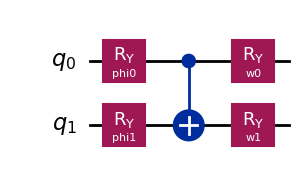

In [16]:
# Create the circuit again to visualize it
qc_viz, inputs, weights = create_qnn_circuit()

# Draw the circuit
# 'mpl' makes it a nice Matplotlib image.
# If that fails, remove 'mpl' to get a text-based drawing.
qc_viz.draw('mpl')

In [17]:
# ==========================================
# 3. Define the Hybrid Architecture
# ==========================================
# Slide 8: "Input ... convert to hidden activations ... act as rotational angle" [cite: 98-117]
class HybridNetwork(nn.Module):
    def __init__(self):
        super(HybridNetwork, self).__init__()

        # --- Classical Part (Feature Extractor) ---
        # Compresses 28x28 image -> 2 features
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 2) # Output 2 features for the 2 qubits

        # --- Quantum Part (Classifier) ---
        self.qnn = qnn_layer

        # --- Post-processing ---
        # Map 2-qubit measurement -> 1 output (probability of class 1)
        # We'll stick a small linear layer to interpret the QNN output flexibly
        self.fc_out = nn.Linear(1, 1)

    def forward(self, x):
        # Classical Flow
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # Shape: (batch, 2)

        # At this point, 'x' contains the "Hybrid features"
        # We usually scale them by pi to cover the rotation range
        x = torch.tanh(x) * np.pi

        # Quantum Flow
        # The QNN takes the 2 features and processes them
        x = self.qnn(x)

        # The QNN output might be dimension (batch, 2^N) or similar depending on setup
        # For EstimatorQNN with Z observable, it's usually expectation values.
        # Let's sum them or use a final linear layer to decide the class.
        x = torch.sum(x, dim=1, keepdim=True)
        x = torch.sigmoid(self.fc_out(x))

        return x

In [18]:
# ==========================================
# 4. Training Loop
# ==========================================
# Use MPS if available for better performance on Macs
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
model = HybridNetwork().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.BCELoss() # Binary Cross Entropy

print("Starting training...")
loss_list = []

model.train()
for epoch in range(10): # 10 Epochs should be enough for 90%+ on 0 vs 1
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_list.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

Using device: mps
Starting training...
Epoch 1, Loss: 0.4071
Epoch 2, Loss: 0.2305
Epoch 3, Loss: 0.1410
Epoch 4, Loss: 0.0915
Epoch 5, Loss: 0.0612
Epoch 6, Loss: 0.0416
Epoch 7, Loss: 0.0288
Epoch 8, Loss: 0.0203
Epoch 9, Loss: 0.0144
Epoch 10, Loss: 0.0102



Final Test Accuracy: 2115.00%


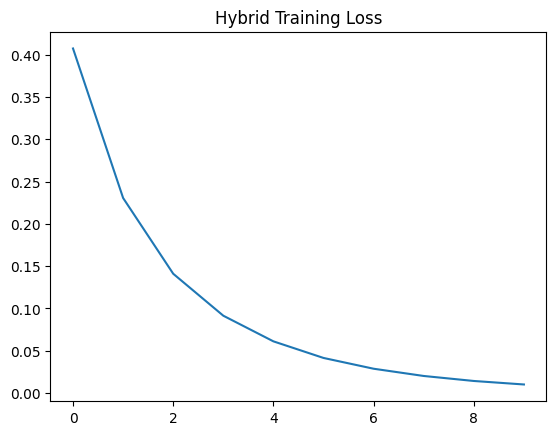

In [19]:
# ==========================================
# 5. Evaluation
# ==========================================
model.eval()
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        # Threshold at 0.5 for binary classification
        pred = (output > 0.5).float().squeeze()
        correct += pred.eq(target).sum().item()

accuracy = correct / len(test_subset)
print(f"\nFinal Test Accuracy: {accuracy * 100:.2f}%")

plt.plot(loss_list)
plt.title("Hybrid Training Loss")
plt.show()